In [2]:
import networkx as nx
import torch
from tqdm import trange, tqdm

from graph import milp_solve_mds, prepare_graph, mds_is_solved

In [3]:
agent_path = './experiments/2024-11-06-1120/agent_220.pt'
net_path = './experiments/2024-11-06-1120/version_0/checkpoints/epoch=99-step=99.ckpt'
if agent_path:
    agent = torch.load(agent_path)


In [17]:
valid_ds = []
size_eq_mlip = []

n, p = 10, .15
tt_g = 100
graphs = []

print(f'sampling {tt_g} x G{n, p}')
for i in trange(tt_g):
    g = prepare_graph(i, n, p, milp_solve_mds, g_nx=True)
    graphs.append(g)

print(f'solving mds')
for g in tqdm(graphs):

    # Perform an episode of actions
    s = []
    for step in range(n):
        action = agent.select_action(g)
        s.append(action)
        g.x = g.x.clone()
        g.x[action][0] = 0
        if mds_is_solved(g.nx, s):
            break
    g.s = s

    valid_ds.append(all(v in s or len(g.nx[v].keys() & s) > 0 for v in g.nx))
    size_eq_mlip.append(len(s) <= len([i for i in g.y if i]))

sampling 100 x G(10, 0.15)


100%|██████████| 100/100 [00:00<00:00, 770.66it/s]


solving mds


100%|██████████| 100/100 [00:00<00:00, 111.27it/s]


In [18]:
print(f'{100*sum(valid_ds)/tt_g}% valid DS      {100*sum(size_eq_mlip)/tt_g}% equivalent to MILP')

53.0% valid DS      2.0% equivalent to MILP


In [19]:
graphs[0].s

[8, 9, 0, 6, 3, 9, 2, 2, 0, 2]

[2, 9, 0]


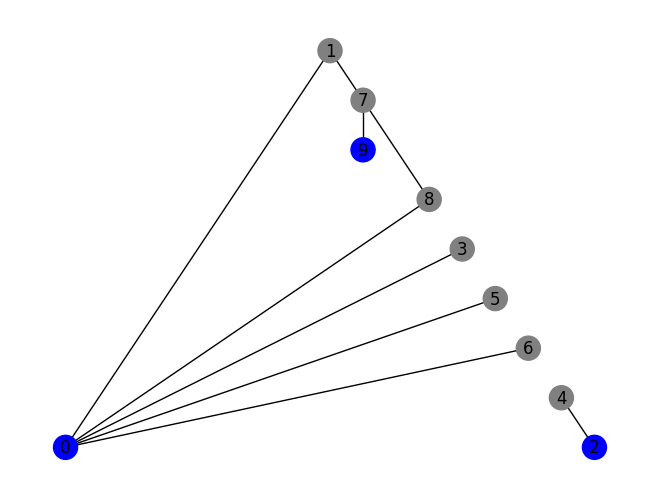

In [21]:
for g in graphs:
    if len(g.s) == len([i for i in g.y if i]):
        break
g_n = g.nx

try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.spring_layout(g_n)

node_colors = ['blue' if n in g.s else 'gray' for n in g.nx]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout)
print(g.s)

In [24]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[1]] * n)
agent.gnn(node_feats, edge_index).squeeze()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)